<a href="https://colab.research.google.com/github/rybread1/deep_image/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import PIL

import IPython.display as display
import numpy as np
import time
import functools
from os import mkdir, path
import json


import IPython.display as display
from deep_image.histogram_loss import hist_match, hist_loss

In [1]:
!git clone https://github.com/rybread1/deep_image.git

Cloning into 'deep_image'...
remote: Enumerating objects: 514, done.
remote: Counting objects: 100% (514/514), done.
remote: Compressing objects: 100% (466/466), done.
remote: Total 514 (delta 101), reused 382 (delta 31), pack-reused 0
Receiving objects: 100% (514/514), 25.81 MiB | 17.12 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [27]:
import importlib
from deep_image import histogram_loss
from deep_image import style_transfer
importlib.reload(style_transfer)
importlib.reload(histogram_loss)

<module 'deep_image.histogram_loss' from '/content/deep_image/histogram_loss.py'>

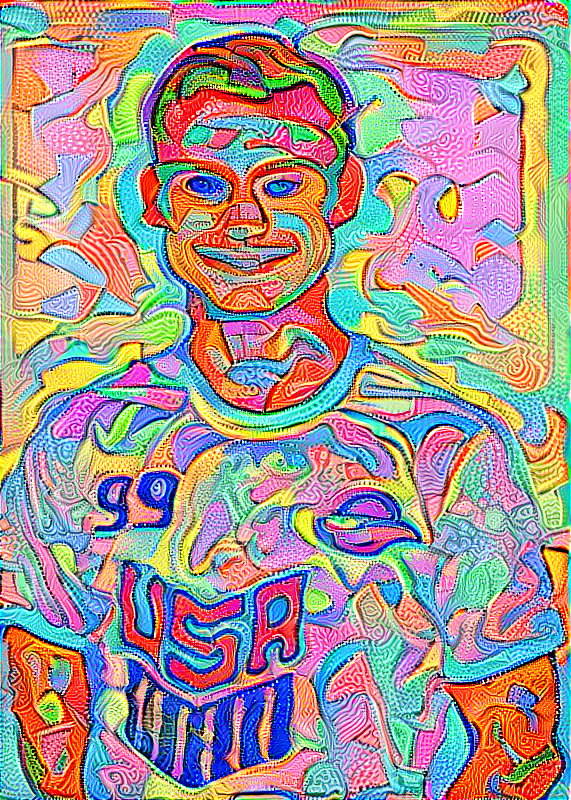

Train step: 1000


In [30]:
style_transfer.style_transfer(style_path='/content/dragon.jpg', 
                              content_path='/content/Tristan-Van-De-Moortele.jpg',
                              style_weight=1000,
                              content_weight=1,
                              content_layers=('block4_conv1',),
                              style_layers=('block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'),
                              style_layer_weights=(0.1, 0.2, 0.5, 0.8, 1),
                              gram_offset=1,
                              learning_rate=0.005,
                              total_variation_weight=0.001,
                              epochs=10,
                              steps_per_epoch=100,
                              content_grey=False,
                              style_grey=False,
                              average_pool_layers=True,
                              max_dim=800,
                              save_folder='/content/tvd')

In [ ]:
def _gram_matrix(input_tensor):
    offset = 1
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor[:,offset:,offset:,:], input_tensor[:,:-offset,:-offset,:])
    input_shape = tf.shape(input_tensor[:,offset:,offset:,:])
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

    # result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    # input_shape = tf.shape(input_tensor)
    # num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    # return result / num_locations

def _vgg_layers(layer_names, avg_pool=False):

    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    if avg_pool:
      vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
      vgg.trainable = False

      layers = vgg.layers

      x = layers[0].output
      for i in range(1, len(layers)):
        if i in [3, 6, 11, 16, 21]:
          x = tf.keras.layers.AveragePooling2D()(x)
        else:
          x = layers[i](x)

      vgg_new = tf.keras.Model(inputs=[layers[0].input], outputs=x)

      layer_names = style_layers + content_layers
      outputs = [vgg_new.get_layer(name).get_output_at(1) for name in layer_names]
      model = tf.keras.Model([vgg_new.input], outputs)
      return model
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model


def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


def _tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)


def _load_img(path_to_img, max_dim, grey=False):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    if grey:
        img = tf.image.rgb_to_grayscale(img)
        img = tf.squeeze(tf.stack([img, img, img], axis=2))
        
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img


def save_image(image, filename):
    """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save to.
  """
    if not isinstance(image, PIL.Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = PIL.Image.fromarray(tf.cast(image, tf.uint8).numpy())
    image.save("%s.jpg" % filename)
    print("Saved as %s.jpg" % filename)


def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers, average_pool=False):
        super(StyleContentModel, self).__init__()
        self.vgg = _vgg_layers(style_layers + content_layers, average_pool)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [_gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}




In [ ]:
style_path='/content/66904916-crying-girl-done-in-neon-art-.jpg'
content_path='/content/5debd36e675ba871a878157c_5debcf5a675ba8190a77f9ba_sean-keegan.png'
style_weight=1000
content_weight=1
learning_rate=0.005
total_variation_weight=0.01
epochs=20
steps_per_epoch=100
content_grey=False
style_grey=False
max_dim=600
average_pool=False
save_folder='/content/test3'


param_dict = {
    'style_path': style_path,
    'content_path': content_path,
    'style_weight': style_weight,
    'content_weight': content_weight,
    'learning_rate': learning_rate,
    'total_variation_weight': total_variation_weight,
    'epochs': epochs,
    'steps_per_epoch': steps_per_epoch,
    'content_grey': content_grey,
    'style_grey': style_grey,
    'average_pool': average_pool,
    'max_dim': max_dim,
}

if not path.isdir(save_folder):
  mkdir(path.join(save_folder))

with open(f'{save_folder}/params.json', 'w') as outfile:
  json.dump(param_dict, outfile)

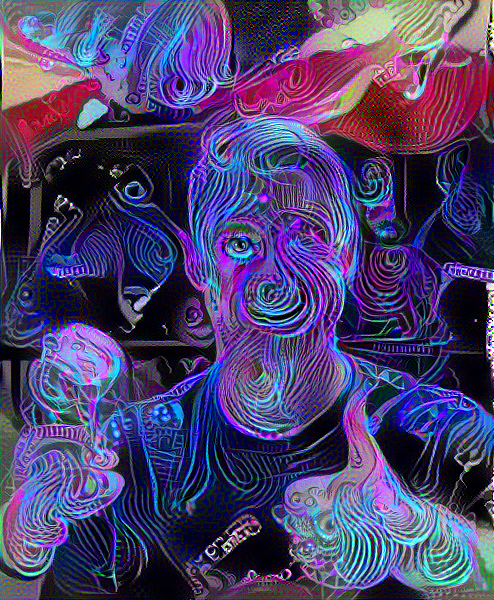

Train step: 2000


In [ ]:
content_image = _load_img(content_path,max_dim, grey=content_grey)
style_image = _load_img(style_path, max_dim, grey=style_grey)

content_layers = ['block4_conv1']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

extractor = StyleContentModel(style_layers, content_layers, average_pool=average_pool)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

opt = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=0.99, epsilon=1e-2)

def style_content_loss(outputs, image):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # histogram_loss = (hist_loss(content_outputs['block4_conv1'], style_targets['block4_conv1'])) * 0.00001

    # style_weights = dict(zip(style_layers, [0.99, 0.5, 0.3, 0.1, 0.01]))
    style_weights = dict(zip(style_layers, [0.1, 0.2, 0.5, 0.8, 1]))

    # losses = []
    # for name in style_outputs.keys():
    #   if name == 'block5_conv1':
    #     conv1_loss = tf.reduce_mean((tf.math.abs((style_outputs[name] - style_targets[name]))) * style_weights[name]) + (total_variation_weight * (tf.image.total_variation(image)))
    #     losses.append(tf.squeeze(conv1_loss))
    #   else:
    #     losses.append((tf.reduce_mean(tf.math.abs((style_outputs[name] - style_targets[name])))) * style_weights[name])
  
    # style_loss = tf.add_n(losses)
    # style_loss *= style_weight / num_style_layers

    style_loss = tf.add_n([tf.reduce_mean(tf.math.abs((style_outputs[name] - style_targets[name]))) * style_weights[name]
                      for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean(tf.math.abs((content_outputs[name] - content_targets[name])))
                              for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss, content_loss, style_loss

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss, content_loss, style_loss = style_content_loss(outputs, image)
        loss += total_variation_weight * tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss, content_loss, style_loss



image = tf.Variable(content_image)

step = 0
losses = []
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        loss, content_loss, style_loss = train_step(image)
        losses.append(loss)

        if m % 20 == 0:
          print('content loss:', content_loss, 'style loss:', style_loss)
        
    if save_folder:
        save_image(_tensor_to_image(image), os.path.join(save_folder, f'epoch-{n}'))

    display.clear_output(wait=True)
    display.display(_tensor_to_image(image))
    print("Train step: {}".format(step))